In [4]:
import sys
sys.path.append('/HighResMDE/src')

from PIL import Image
import torch
import torch.nn as nn
import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader
from layers.depth_to_normal import Depth2Normal
from dataloader.BaseDataloader import BaseImageDataset
from dataloader.NYUDataloader import NYUImageData
from layers.DN_to_distance import DN_to_distance
from torchvision import transforms
import matplotlib.pyplot as plt


In [5]:
BATCH_SIZE = 4

train_dataset = BaseImageDataset('train', NYUImageData, '/scratchdata/nyu_data/', '/HighResMDE/src/nyu_train.csv')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)

normal_estimation = Depth2Normal().to('cuda')
blur = transforms.GaussianBlur(kernel_size=5)
dn_to_distance = DN_to_distance(BATCH_SIZE, 480, 640).to("cuda")

In [6]:
loop = tqdm.tqdm(train_dataloader, unit="batch")
for itr, x in enumerate(loop):
    for k in x.keys():
        x[k] = x[k].to('cuda')
    depth_gt = x["depth_values"] #Unit: m
    #print("gt", depth_gt.max())
    normal_gt, x["mask"] = normal_estimation(depth_gt, x["camera_intrinsics"], x["mask"], 1.0) # TODO: Figure out what scale does
    normal_gt = torch.stack([blur(each_normal) for each_normal in normal_gt])
    normal_gt = F.normalize(normal_gt, dim=1, p=2) #Unit: none, normalised
    dist_gt = dn_to_distance(depth_gt, normal_gt, x["camera_intrinsics_inverted"]) #Unit: m
    break

  0%|          | 0/12672 [00:00<?, ?batch/s]


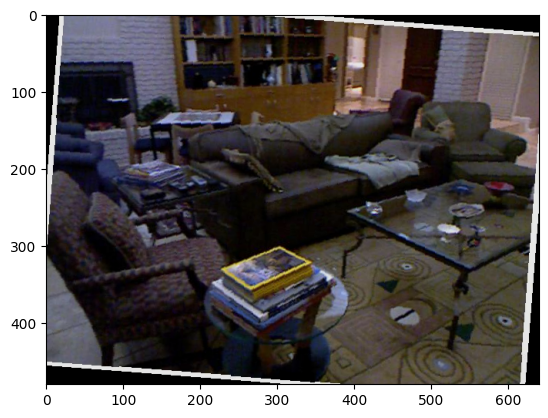

In [12]:
plt.imshow(x["pixel_values"][0].permute(1,2,0).cpu().numpy())

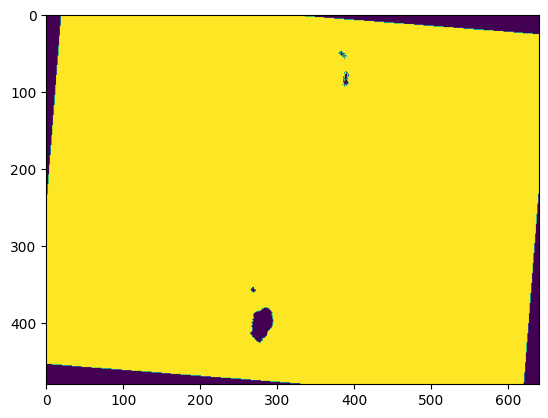

In [27]:
plt.imshow(x["depth_values"][0].permute(1,2,0).cpu().numpy())

In [18]:
print(normal_gt[0].shape)

torch.Size([3, 480, 640])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.9999956].


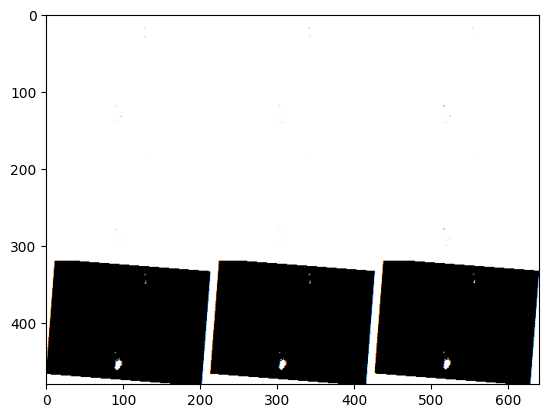

In [11]:
plt.imshow(normal_gt[0].detach().cpu().numpy().squeeze().reshape(480, 640, 3) + 1)